In [2]:
import numpy as np
import scipy
import h5py
import matplotlib
# or whatever backend you prefer
%matplotlib inline 
import matplotlib.pyplot as plt
import so3g
from so3g.proj import coords, quat
import sotodlib.coords.planets as planets
from scipy.optimize import curve_fit

In [3]:
# Let's first load an example timestream of a Jupiter simulation at 90 GHz.
# These are 1-hour constant elevation scans of Jupiter from the Atacama Desert in Chile,
# assuming decent weather conditions

hdf5_file_path = 'tod_example_Jupiter_90GHz_pwv1mm_const_wspeed.h5'

with h5py.File(hdf5_file_path, 'r') as hdf5_file:
    ctime = hdf5_file['ctime'][:]
    bore_az, bore_el = hdf5_file['boresight_coords'][:]
    # Signal is stored as an array of size (ndets, nsamps)
    signal = hdf5_file['timestreams'][:]

In [4]:
# Let's also do some basic filtering of the data: 
#        1. 'detrending', 
#        2. high-pass filter for 1/f noise 
#       (3. low-pass filter)

# ** Tips: 
#          -Generally: for the frequency cutoffs one can look at the PSD of the data. 
#          -If there is indeed a HWP in the setup the low-frequency cutoff should be a bit less than the HWP rate.


# 1. Detrending: detrending is about removing the individual trends associated to data of different detectors.
# A good start here is to subtract the mean of each detector's timestream. What else would you add?

detr_signal = signal.copy()
for det_i in range(signal.shape[0]):
    
    detr_signal[det_i] -= detr_signal[det_i].mean() 
    
# What else would you add here?


# 2.,3. Fourier filtering

def fourier_filter(data, fs=200, cutoff_high=0.2, cutoff_low=1.8, btype='high', order=5):

    '''Args:
    ----
    cutoff_high, cutoff_low: cuttoff frequencies
    fs: sampling rate
    btype: low, high, bandpass

    '''

    nyq = 0.5 * fs
    normal_cutoff_high = cutoff_high / nyq
    #normal_cutoff_low = cutoff_low / nyq
    b, a = scipy.signal.butter(order, normal_cutoff_high, btype='high', analog=False)
    y = scipy.signal.filtfilt(b, a, data)
    return y

filt_signal = np.array([fourier_filter(detr_signal[det_i]) for det_i in range(detr_signal.shape[0])])


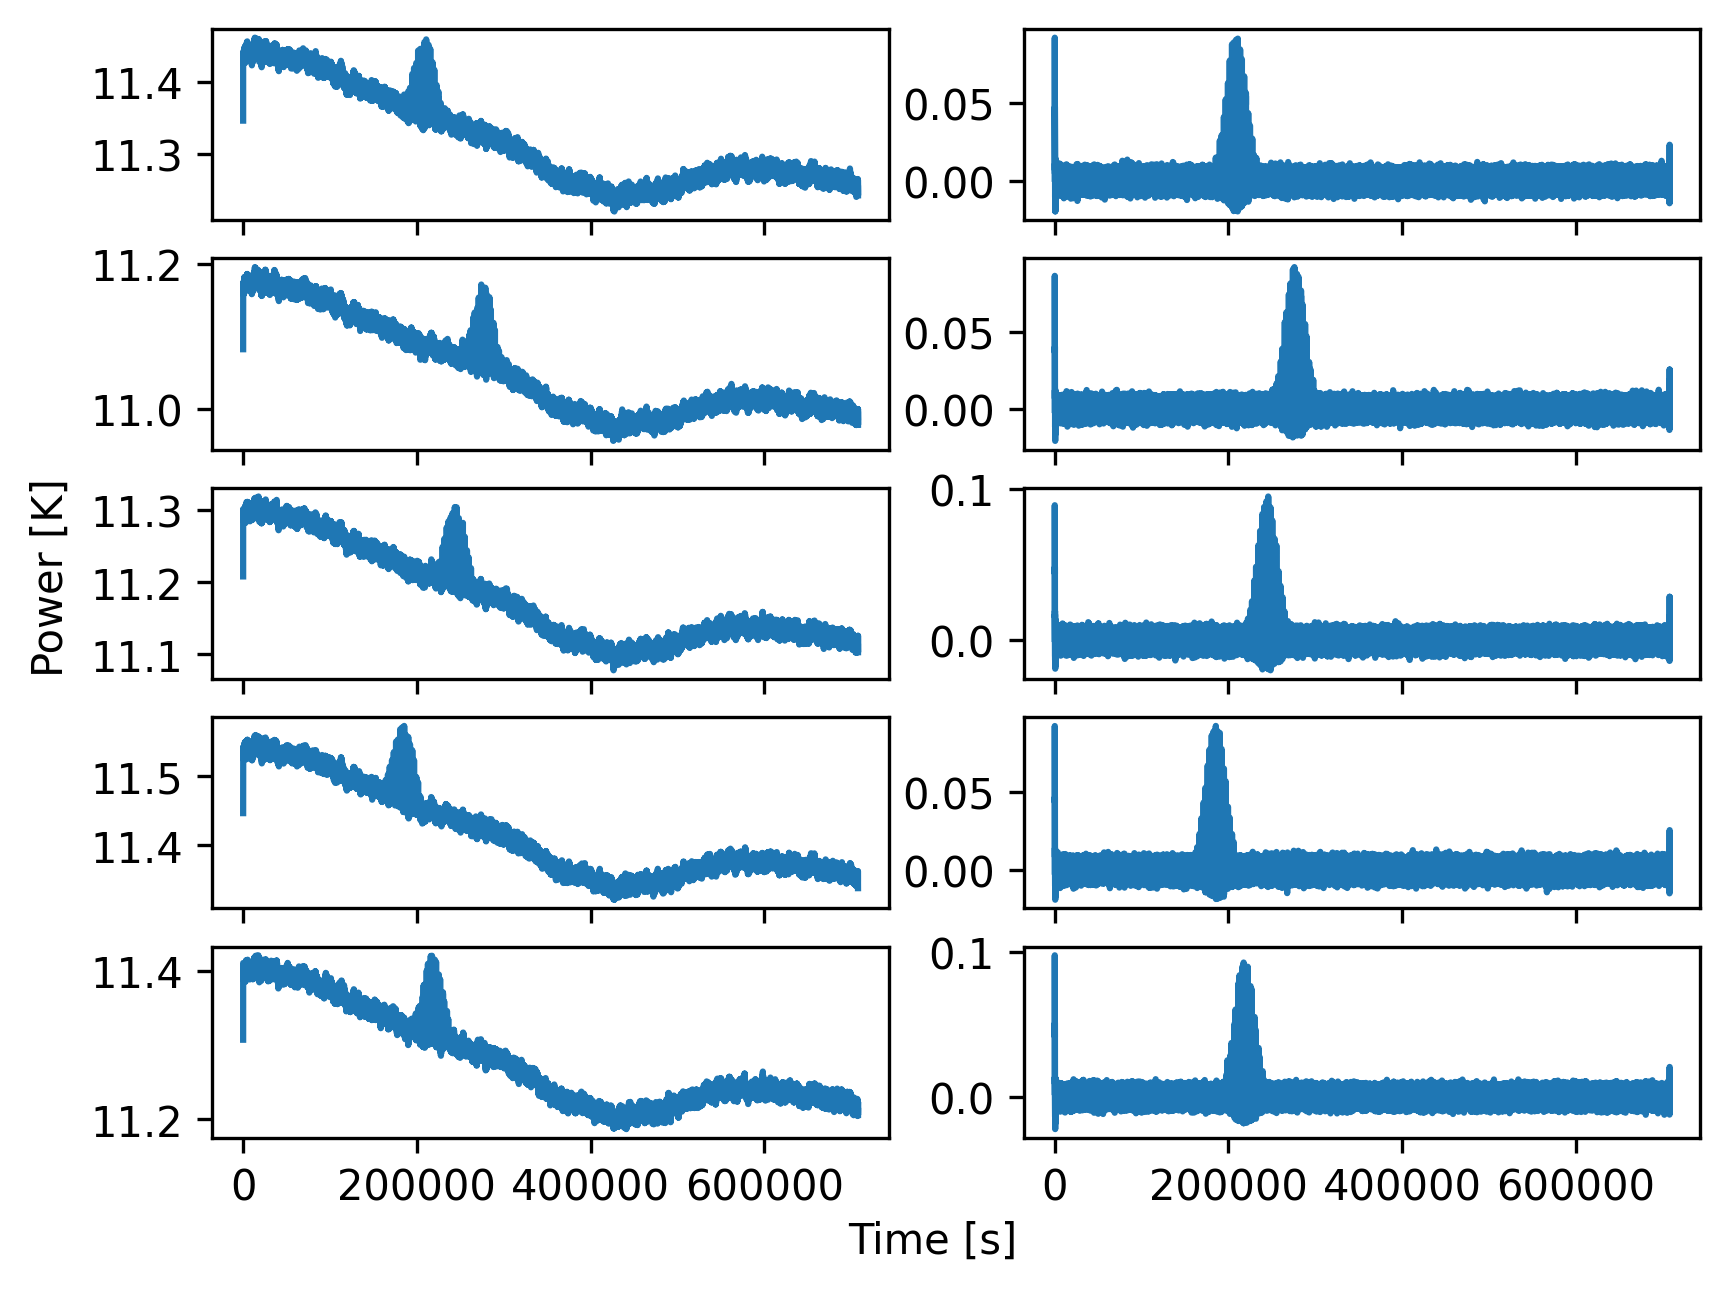

In [5]:
# Take a look at the data before vs. after high-passing for a few (n_samp_dets) detectors
n_samp_dets = 5
samp_dets = np.random.randint(0, signal.shape[0], n_samp_dets)
fig, axs = plt.subplots(n_samp_dets, 2, sharex=True, dpi=300)

for det_idx,det_i in enumerate(samp_dets):
    axs[det_idx][0].plot(signal[det_i])
    axs[det_idx][1].plot(filt_signal[det_i])
    
fig.text(0.5, 0.03, 'Time [s]', ha='center')
fig.text(0.03, 0.5, 'Power [K]', va='center', rotation='vertical')

plt.show()
plt.close()

In [6]:
# P.S. Fourier filters tend to keep the average power of the data and thus create these spikes at the 
# beginning and end of the timetsreams

# How would you correct for these? Imagine for example you want to make an automated source detection and these
# spikes have very high amplitudes (similar to the amplitude you would expect from a bright planet).

# We do the dummy case here and just truncate the data cutting about ~1000 samples from the beginning and end
# of the timeseries.

data_trunc = filt_signal[:,1000:-1000]
ctime_trunc = ctime[1000:-1000]
bore_az_trunc = bore_az[1000:-1000]
bore_el_trunc = bore_el[1000:-1000]

In [7]:
# Now we need to find the detectors that 'see' the source.

# Easy case: assuming calibrated data that allow us to set a threshold for the amplitude corresponding to a planet 
# crossing over the focal plane.

# Hard case: uncalibrated or/and very noisy data -- need to think of some 'tricks' -- What could these be? What 
# would you do?

def dummy_src_detection(data, planet):
    
    planet_amps = {'Jupiter':0.08, 'Saturn': 0.01}
    
    dets_w_src, max_peak_idxs = [], []
    for det_i in range(data.shape[0]):
        
        peaks, _ = scipy.signal.find_peaks(data[det_i], planet_amps[planet])
        
        if list(peaks):
            dets_w_src.append(det_i)
            max_peak = np.nanargmax(data[det_i][peaks])
            max_peak_idxs.append(peaks[max_peak])
            
    return dets_w_src, max_peak_idxs


dets_w_src, max_peak_idxs = dummy_src_detection(data_trunc, 'Jupiter')
print('{} detectors see the source'.format(len(dets_w_src)))

860 detectors see the source


# First we calibrate the position of the detectors on the focal plane


In [8]:
# We have a few different coordinate systems here.

# The planet position is typically known in ra/dec coordinates but the telescope boresight is calculated in az/el.
# We use quaternion operations to create a planet-centered coordinate system: ~q_bore * q_obj
# We then decompose the above quaternion product to 'xi, eta' coordinates: a handy system of native focal plane
# coordinates of the SO telescopes (analog to cartesian system where xi, eta are aligned with -az, -el).

# In principle, we can write this transformation ourselves, we just use so3g here (or toast operations)
# for efficiency. See relevant documantation to re-produce the math:

# https://so3g.readthedocs.io/en/latest/proj.html#
# https://github.com/hpc4cmb/toast/blob/master/src/toast/qarray.py

def get_src_centered_tod(q_bore, src_idx, planet):
    
    # We estimate the planet position at its smallest angle with the detector
    d1_unix = ctime[src_idx]
    planet = planets.SlowSource.for_named_source(planet, d1_unix * 1.)
    ra0, dec0 = planet.pos(d1_unix)
    q_obj = quat.rotation_lonlat(ra0, dec0)

    # Assuming there is no prior on the detector position
    q_det = coords.quat.quat(*np.array(~q_bore * q_obj)[src_idx])
    xi0, eta0, gamma0 = quat.decompose_xieta(q_det)

    q_total = ~q_bore * q_obj
    xi, eta, gamma = quat.decompose_xieta(q_total)

    return np.array([xi, eta]), np.array([xi0, eta0])

# Para-phrase this below
# Precise conversion from Earth-based coordinates to celestial coordinates must include the 
# predictable (Precession and Nutation) and unpredictable variations in the Earth’s axis of rotation
csl = so3g.proj.CelestialSightLine.az_el(ctime_trunc, bore_az_trunc, bore_el_trunc, weather="typical")
q_bore = csl.Q

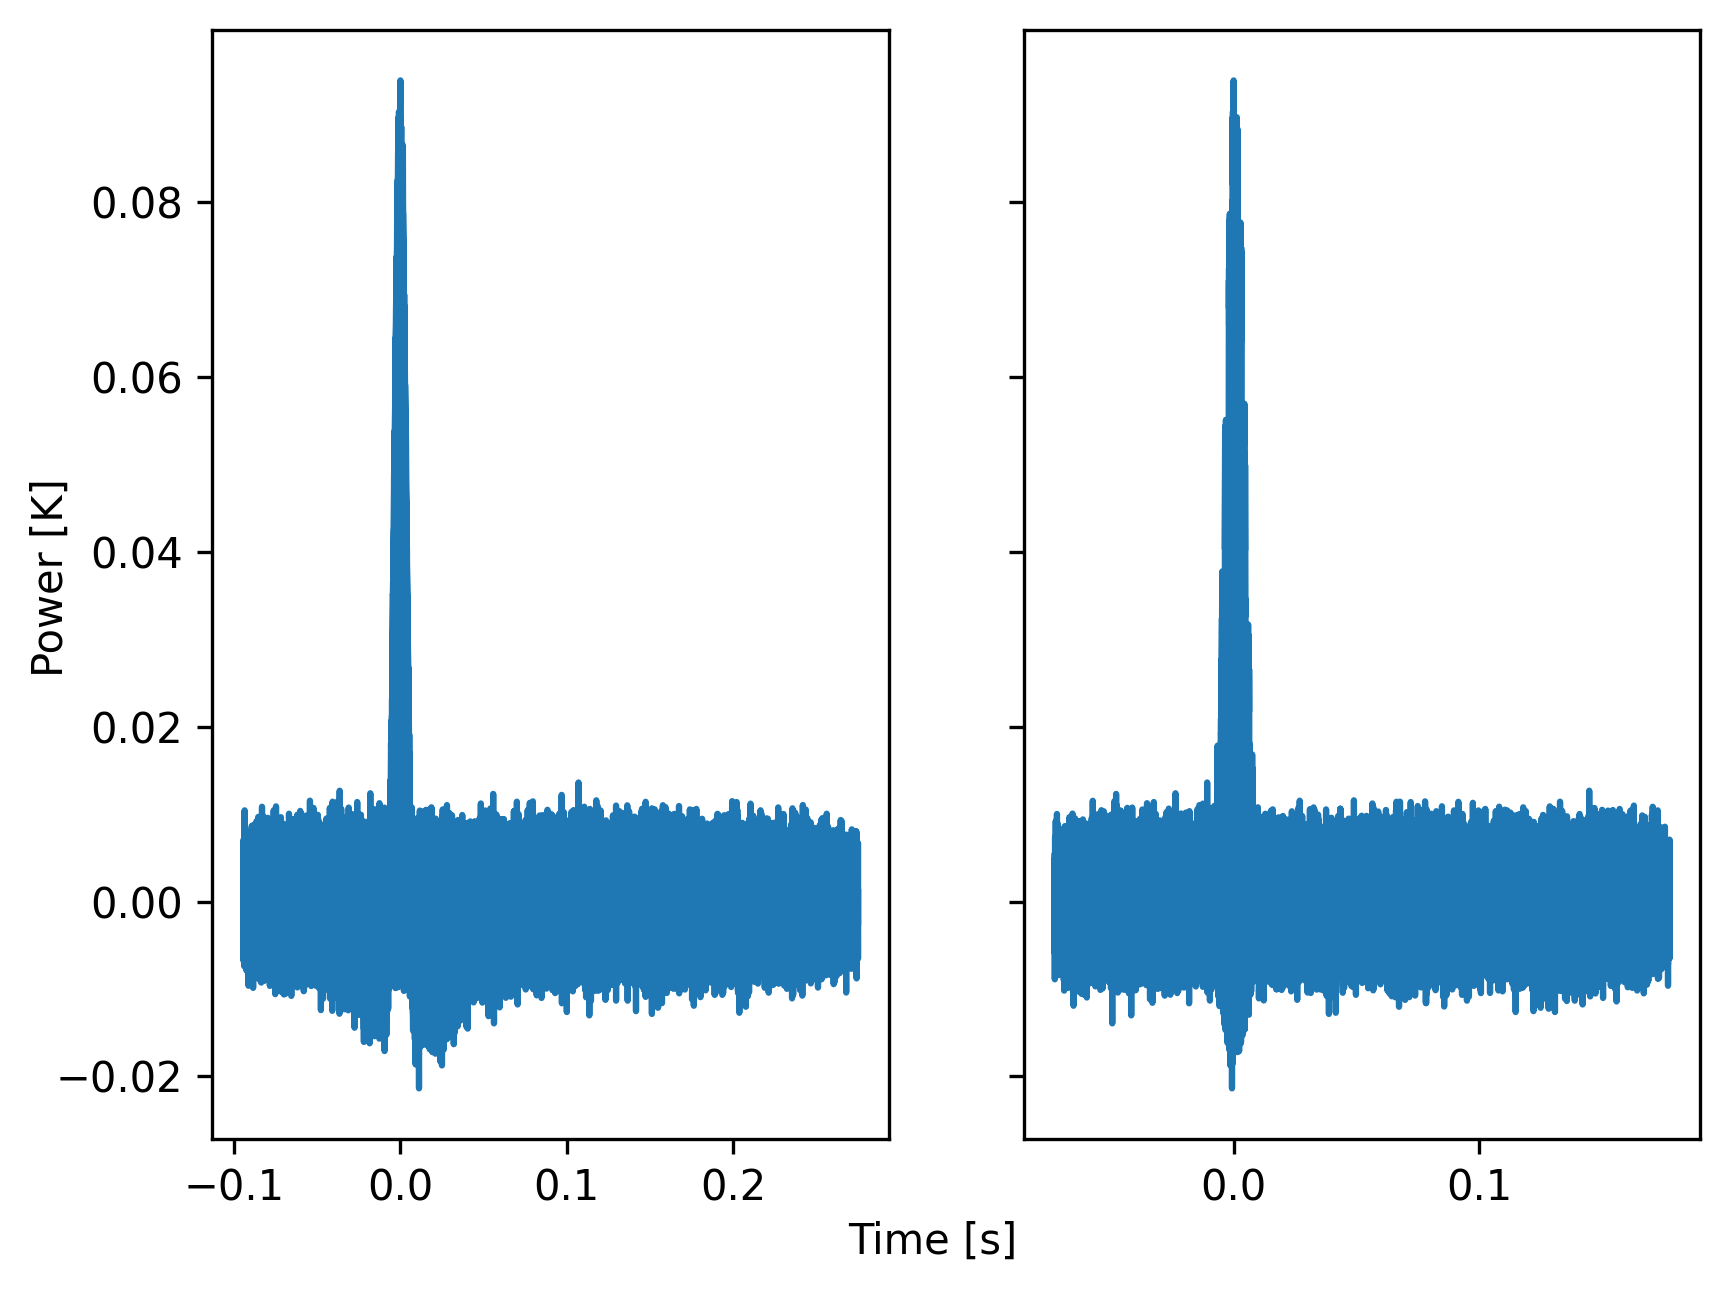

In [9]:
# Check for one random detector
det_idx = np.random.choice(dets_w_src)
p_centered_coords, det_center = get_src_centered_tod(q_bore=q_bore, 
                                                        src_idx=max_peak_idxs[det_idx], 
                                                        planet='Jupiter')

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, dpi=300)
ax1.plot(p_centered_coords[0]-det_center[0], data_trunc[det_idx])
ax2.plot(p_centered_coords[1]-det_center[1], data_trunc[det_idx])

fig.text(0.5, 0.03, 'Time [s]', ha='center')
fig.text(0.03, 0.5, 'Power [K]', va='center', rotation='vertical')

plt.show()
plt.close()

In [10]:
#Truncate the data a bit around the source for efficiency ~ say about 2 degrees.
max_rad = np.radians(2)

xi_det_centered = p_centered_coords[0]-det_center[0]
eta_det_centered = p_centered_coords[1]-det_center[1]

radius = np.sqrt(xi_det_centered ** 2 + eta_det_centered ** 2)
idx_main_in = np.where(radius < max_rad)[0]
xi_main = xi_det_centered[np.array(idx_main_in)]
eta_main = eta_det_centered[idx_main_in]
data_main = data_trunc[det_idx][idx_main_in]

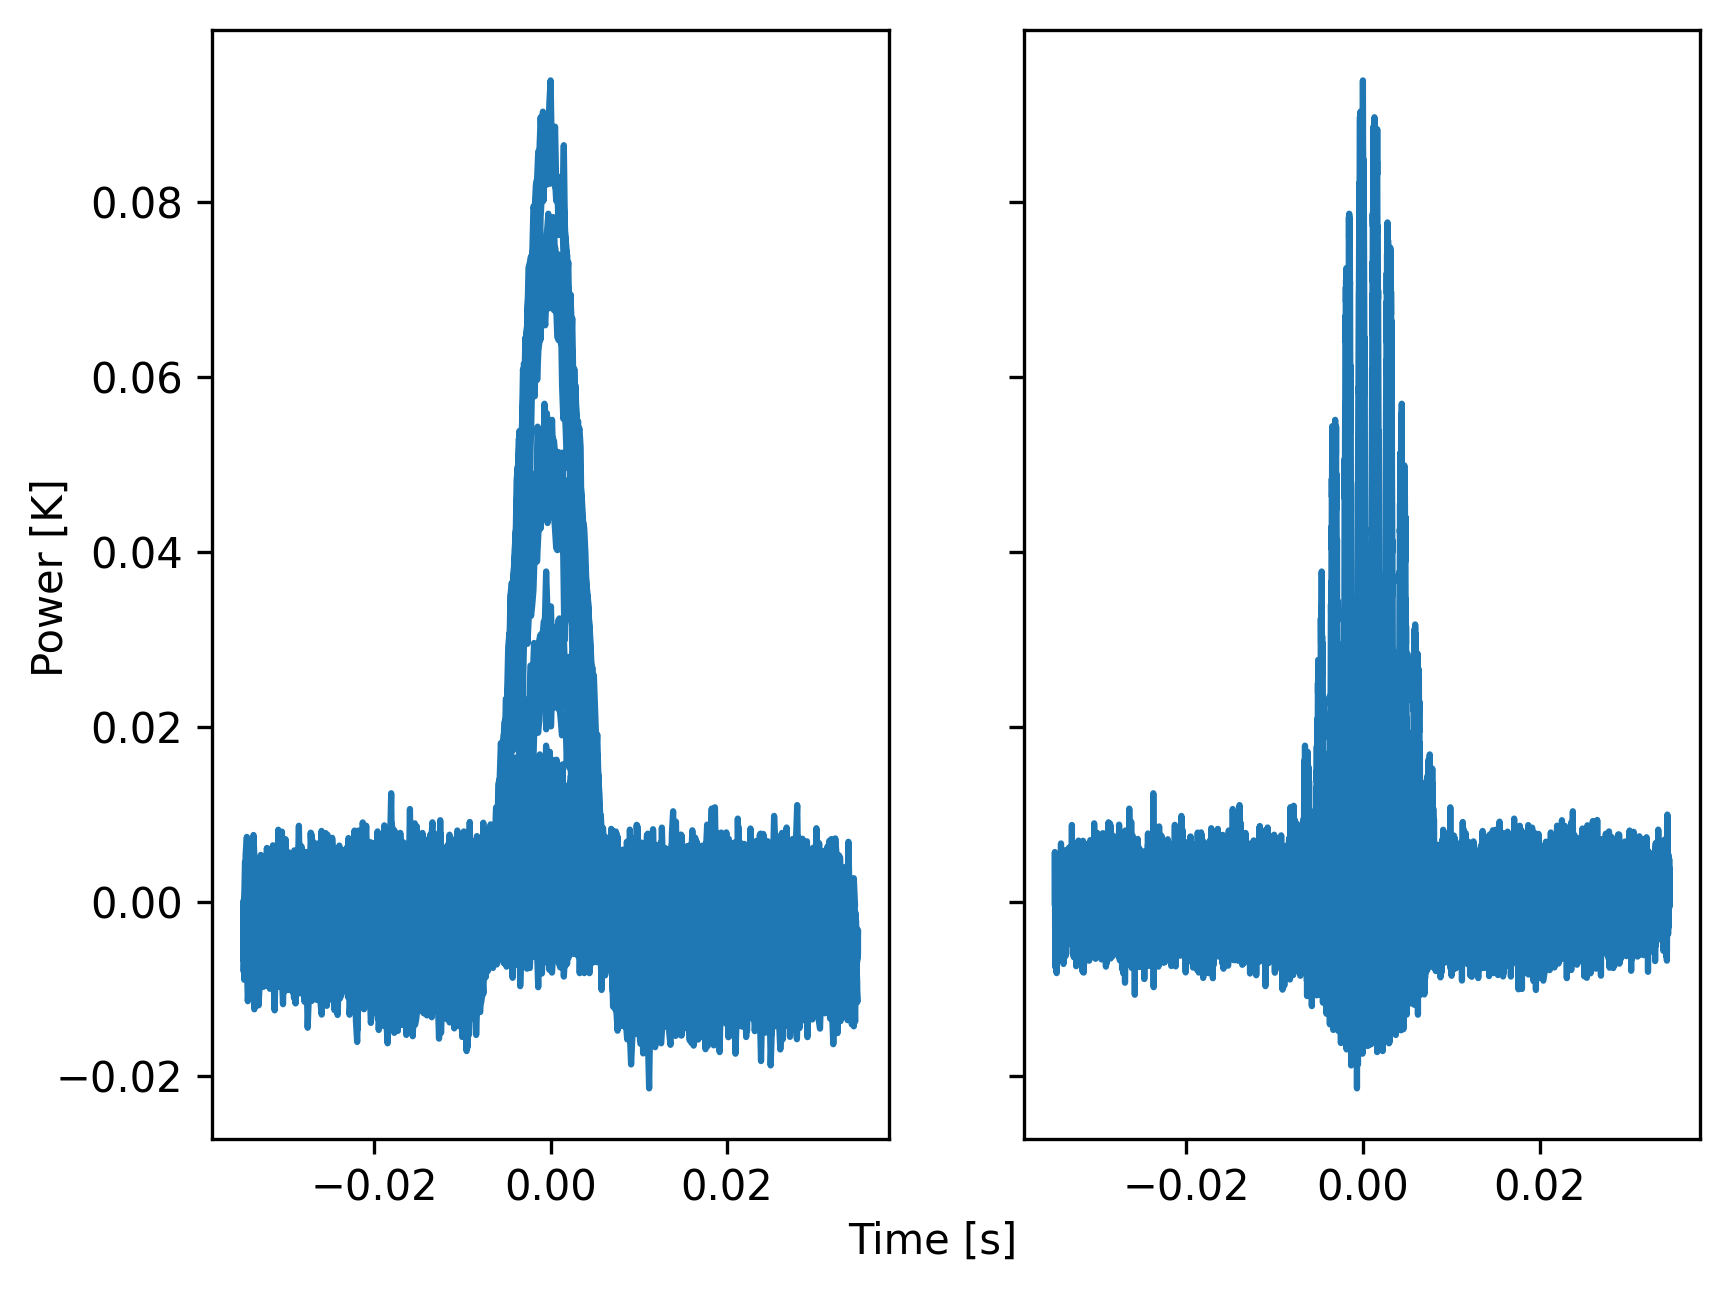

In [11]:
# We scan in azimuth with fixed elevation - scan strategy is captured in the plots
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, dpi=300)
ax1.plot(xi_main, data_main)
ax2.plot(eta_main, data_main)

fig.text(0.5, 0.03, 'Time [s]', ha='center')
fig.text(0.03, 0.5, 'Power [K]', va='center', rotation='vertical')

# ax1.set_xlim(-0.01, 0.01)
# ax2.set_xlim(-0.01, 0.01)

plt.show()
plt.close()

In [12]:
# A planet is a circular point source which will appear roughly like a Gaussian in the timestreams.
# How much the imprint of the source deviates from a Gaussian distribution depends on the telescope beam.
# We model the beam as a Gaussian for now -- What other fitting models could you use? Why? Which components are
# the ones that prove more crucial in beam-forming?

# We can also include the filtering in the modeling -- would you like to try?

def gaussian2d(xi, eta, amp, xi0, eta0, fwhm_xi, fwhm_eta, phi=0):
    """Simulate a time stream with an Gaussian beam model
    Args
    ------
    az, el: cordinates in the detector's system
    amp: float
        amplitude of the Gaussian beam model
    az0, el0: float, float
        center position of the Gaussian beam model
    fwhm_xi, fwhm_eta, phi: float, float, float
        fwhm along the xi, eta axis (rotated)
        and the rotation angle (in radians)

    Ouput:
    ------
    sim_data: 1d array of float
        Time stream at sampling points given by xieta
    """
    xi_rot = xi * np.cos(phi) - eta * np.sin(phi)
    eta_rot = xi * np.sin(phi) + eta * np.cos(phi)
    factor = 2 * np.sqrt(2 * np.log(2))
    xi_coef = -0.5 * (xi_rot-xi0) ** 2 / (fwhm_xi / factor) ** 2
    eta_coef = -0.5 * (eta_rot-eta0) ** 2 / (fwhm_eta / factor) ** 2
    sim_data = amp * np.exp(xi_coef + eta_coef)
    return sim_data

# We add the option of a time constant but not use it in this cell.

def tconst_convolve(ctime, data, tau):
    """Convolve the time stream with a given time constant
    Args
    ------
    ctime: 1d array of float
        containting the ctime of each data point
    data: 1d array of float
        time stream data for a given detector
    tau: float
        time constant to be added to the time stream (in seconds)

    Return
    ------
    data_tau: 1d array of float
        time-constant filtered time stream
    """
    k = int(np.ceil(np.log(len(data)) / np.log(2)))
    n = 2 ** k
    delta_time = np.mean(np.diff(ctime))
    freqs = np.fft.fftfreq(n, delta_time)
    data_pad = np.zeros(n)
    data_pad[: len(data)] = data
    fft_data = np.fft.fft(data_pad)
    fft_data *= 1.0 / (1.0 + 2.0j * np.pi * tau * freqs)
    data_tau = np.fft.ifft(fft_data).real[: len(data)]
    return data_tau

# The simulation function for pointing/beam

def tod_sim(xi_eta_t, amp, xi0, eta0, fwhm_xi, fwhm_eta, phi, idx_main, tau):
    """ Simulate the TOD of a single detector
    Args
    ----
    xi_eta_t: stacked array of xi, eta, ctime
    idx_main: range of integers serving as data indices to select a region around
              the peak of radius max_rad.
    """
    xi, eta, ctime = xi_eta_ctime
    data_sim = gaussian2d(
        xi, eta, amp, xi0, eta0, fwhm_xi, fwhm_eta, phi
    )

    if tau == 0.0:
        return data_sim[idx_main]
    data_sim_tau = tconst_convolve(ctime, data_sim, tau)
    return data_sim_tau[idx_main]

# We make some initial assumptions about the beam sizes and take the source amplitude guess directly 
# from the data.

# The beam size assumptions are informed from TICRA TOOLS (former GRASP) simulations. 
# Assuming a circular beam we set:
beamsize_93 = 27.4
fwhm_xi, fwhm_eta = np.radians(beamsize_93/60), np.radians(beamsize_93/60)
amp = data_trunc[det_idx][max_peak_idxs[det_idx]]

# random angle
theta_init = np.pi/6

# Set bounds to pointing and beam parameters
p0 = [amp, 0, 0, fwhm_xi, fwhm_eta, theta_init] 

# Errors 
# *beam error is expressed as %initial guess
amp_error = 0.01
xi0_error, eta0_error = 0.005, 0.005
fwhm_xi_error, fwhm_eta_error = 0.1, 0.1
theta_min, theta_max = 0, np.pi

# What is a typical bound to set for the detector position? - What bounds would you set here?
# According to your experience, is it better to set tight bounds from the beginning or widen the allowed
# parameter range and cut detectors after?
fwhm_min_xi = fwhm_xi - (fwhm_xi_error * fwhm_xi)
fwhm_max_xi = fwhm_xi + (fwhm_xi_error * fwhm_xi)

fwhm_min_eta = fwhm_eta - (fwhm_eta_error * fwhm_eta)
fwhm_max_eta = fwhm_eta + (fwhm_eta_error * fwhm_eta)


bounds_min = (amp - (amp_error * amp), -xi0_error, -eta0_error, fwhm_min_xi, fwhm_min_eta, theta_min)
bounds_max = (amp + (amp_error * amp), xi0_error, eta0_error, fwhm_max_xi, fwhm_max_eta, theta_max)
bounds = np.array((bounds_min, bounds_max,))
    

# Attempt to fit the pointing
f = lambda xyt, *pointing: tod_sim(xyt,
                                   pointing[0], 
                                   pointing[1], 
                                   pointing[2], 
                                   p0[3], 
                                   p0[4], 
                                   p0[5], 
                                   idx_main_in, 
                                   tau=0.0)

xi_eta_ctime = np.vstack([xi_det_centered, eta_det_centered, ctime_trunc])
try:
    popt_pointing, _ = curve_fit(f, 
                                 xi_eta_ctime, 
                                 data_main, 
                                 p0=p0[:3], 
                                 bounds=bounds[:, :3])
except BaseException:
    print('Pointing fitting failed')

In [13]:
# Fitted detector centers and amplitude
amp, xi0, eta0 = popt_pointing

# Re-center the data and update initial guess
p0[0] = popt_pointing[0]

xi_det_centered -= popt_pointing[1]
eta_det_centered -= popt_pointing[2]
xi_eta_ctime = np.vstack((xi_det_centered, eta_det_centered, ctime_trunc))

# Truncate again the region around the source
radius = np.sqrt(xi_det_centered ** 2 + eta_det_centered ** 2)
idx_main_in = np.where(radius < max_rad)[0]
xi_main = xi_det_centered[idx_main_in]
eta_main = eta_det_centered[idx_main_in]
data_main = data_trunc[det_idx][idx_main_in]

# Note: the reason we still keep the full data vector in the fitting is in case we want to
# also include the time-constant convolution

amp = popt_pointing[0]
# The detector centroids are the initial positions we determined from the
# peak amplitude plus fitted offsets
xi0_fitted = xi0 + popt_pointing[1]
eta0_fitted = eta0 + popt_pointing[2]

# Fit the beam parameters
f = lambda xyt, *beam: tod_sim(xyt, 
                               p0[0], 
                               p0[1], 
                               p0[2], 
                               beam[0], 
                               beam[1], 
                               beam[2],
                               idx_main_in, 
                               tau=0.0)
try:
    popt_beam, _ = curve_fit(f, 
                             xi_eta_ctime, 
                             data_main, 
                             p0=p0[3:], 
                             bounds=bounds[:, 3:])
except BaseException:
    print('Beam fitting failed')

fwhm_xi, fwhm_eta, phi = popt_beam

In [14]:
# Compare the fitted to the raw data

data_sim_main = gaussian2d(
            xi_main,
            eta_main,
            amp,
            xi0_fitted,
            eta0_fitted,
            fwhm_xi,
            fwhm_eta,
            phi=0)

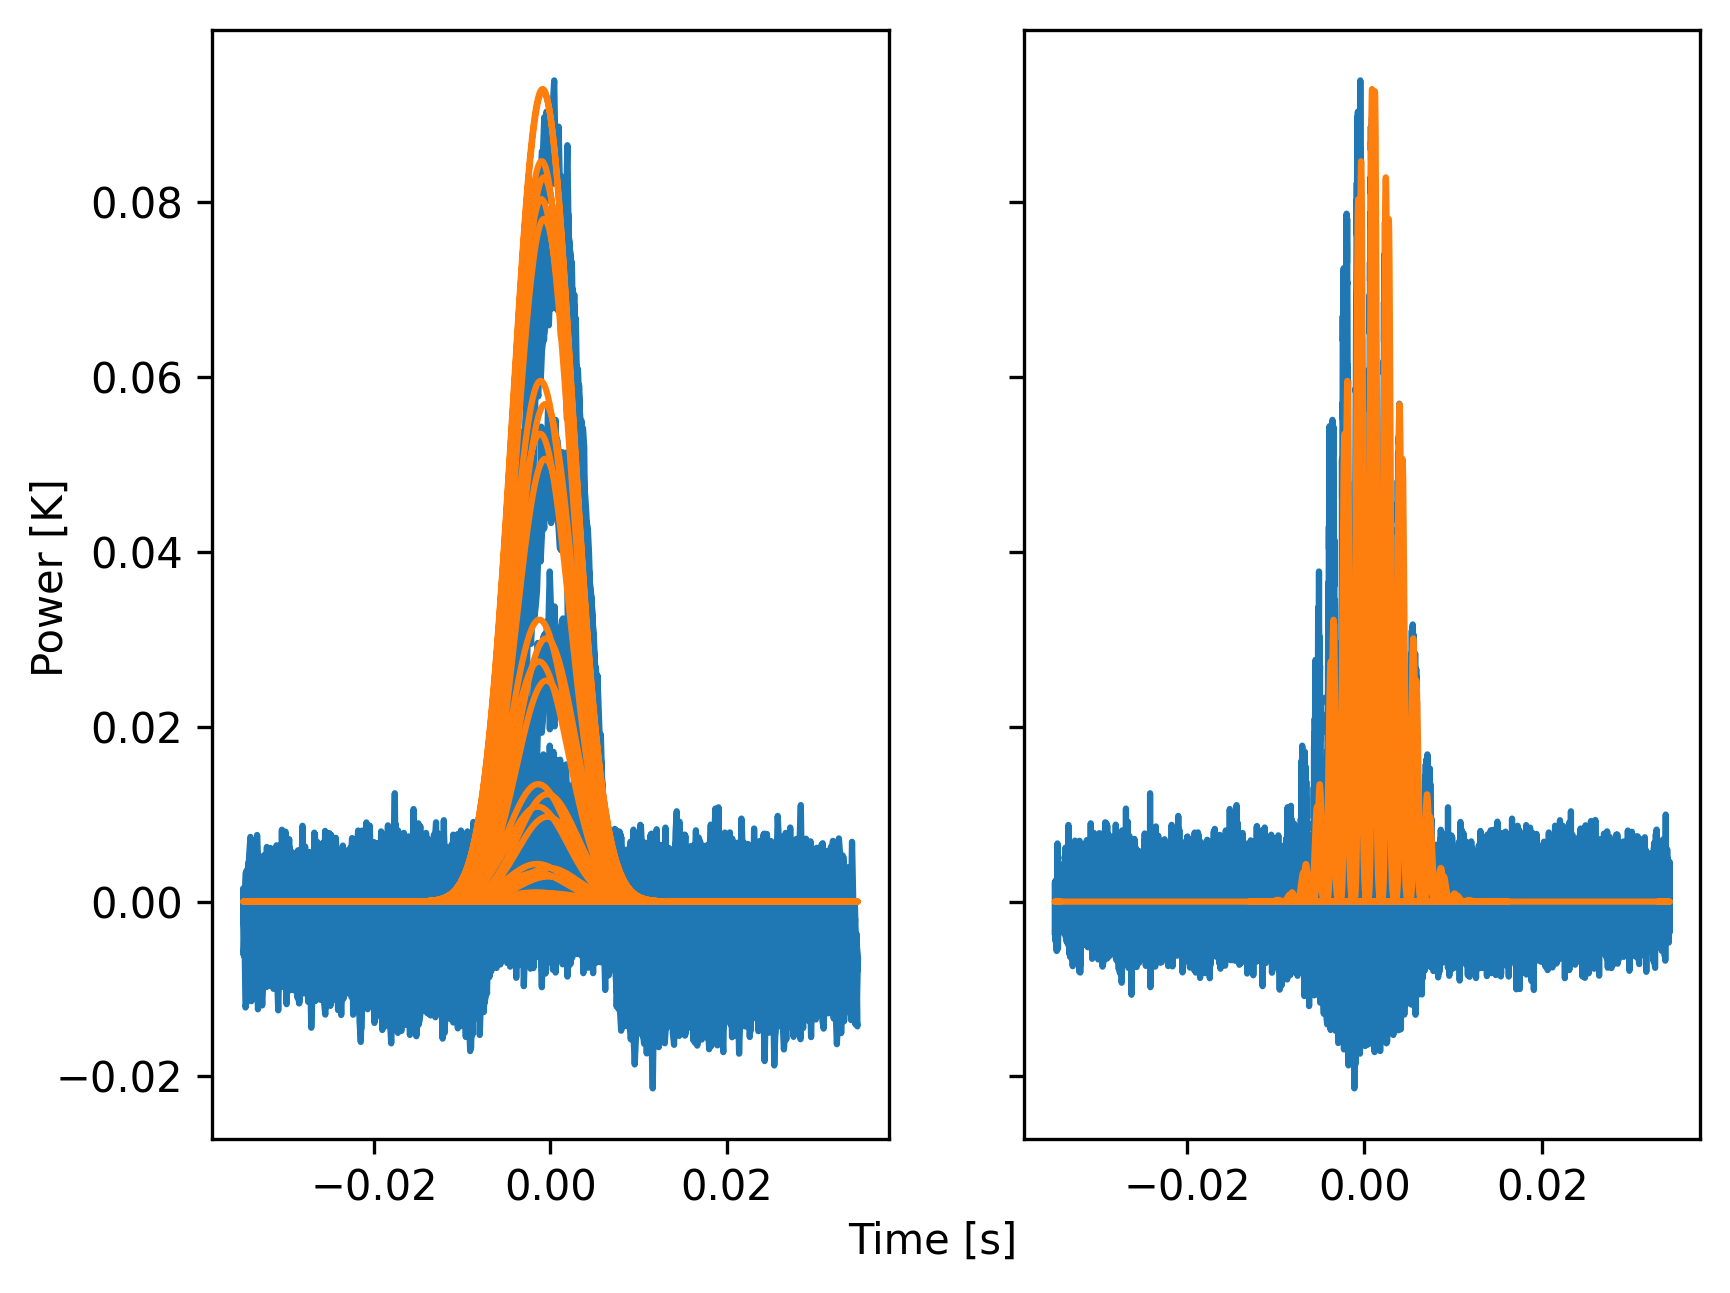

In [15]:
# We scan in azimuth with fixed elevation - scan strategy is captured in the plots
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, dpi=300)
ax1.plot(xi_main, data_main)
ax1.plot(xi_main, data_sim_main)

ax2.plot(eta_main, data_main)
ax2.plot(eta_main, data_sim_main)

fig.text(0.5, 0.03, 'Time [s]', ha='center')
fig.text(0.03, 0.5, 'Power [K]', va='center', rotation='vertical')

# ax1.set_xlim(-0.01, 0.01)
# ax2.set_xlim(-0.01, 0.01)

plt.show()
plt.close()

In [16]:
# We see a shift in the zero position of the distrubution. Why could this be? Try fitting for the time constant 
# and see if this changes. A good initial guess and boundaries are 3 ms and 1 ms < tau < 10 ms.

In [17]:
# Now try to run this for a larger set of detectors - potentially for the full wafer (all detectors included).
# You can compare your results with ours stored in the file in the format of a pandas dataframe. 
import pandas as pd
fitted_parameters_nadia_alex = pd.read_hdf('fitted_parameters_example_Jupiter_90GHz_pwv1mm_const_wspeed.h5')

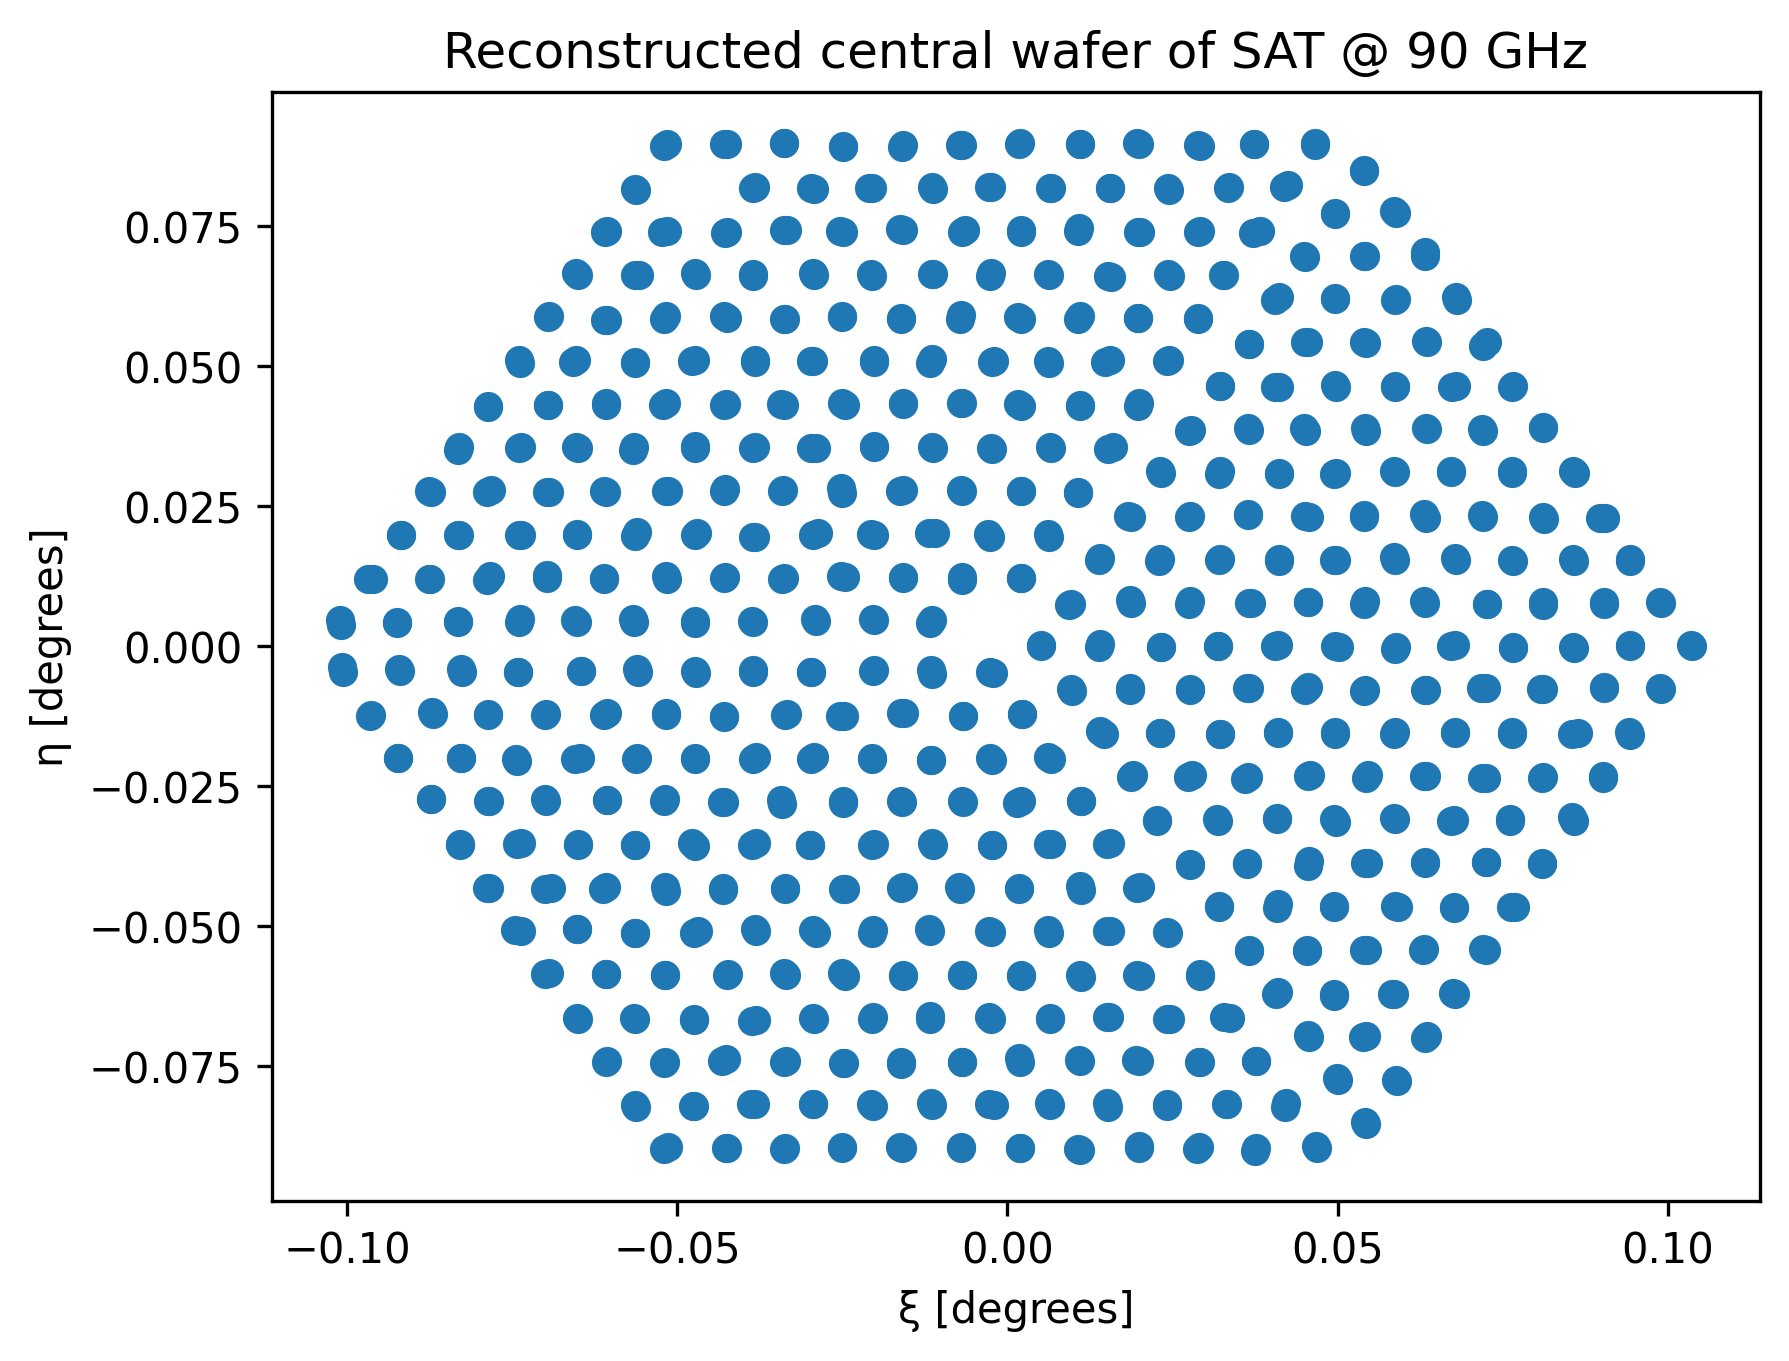

In [21]:
# Does it merely look like part of an actual focal plane? Hopefully! 
xi_fitted, eta_fitted = df['xi0'].to_numpy().astype(float), df['eta0'].to_numpy().astype(float)

fig = plt.figure(dpi=300)
ax = fig.add_subplot(111)
ax.scatter(xi_fitted, eta_fitted)
ax.set_xlabel('ξ [degrees]')
ax.set_ylabel('η [degrees]')
ax.set_title('Reconstructed central wafer of SAT @ 90 GHz')

plt.show()
plt.close()

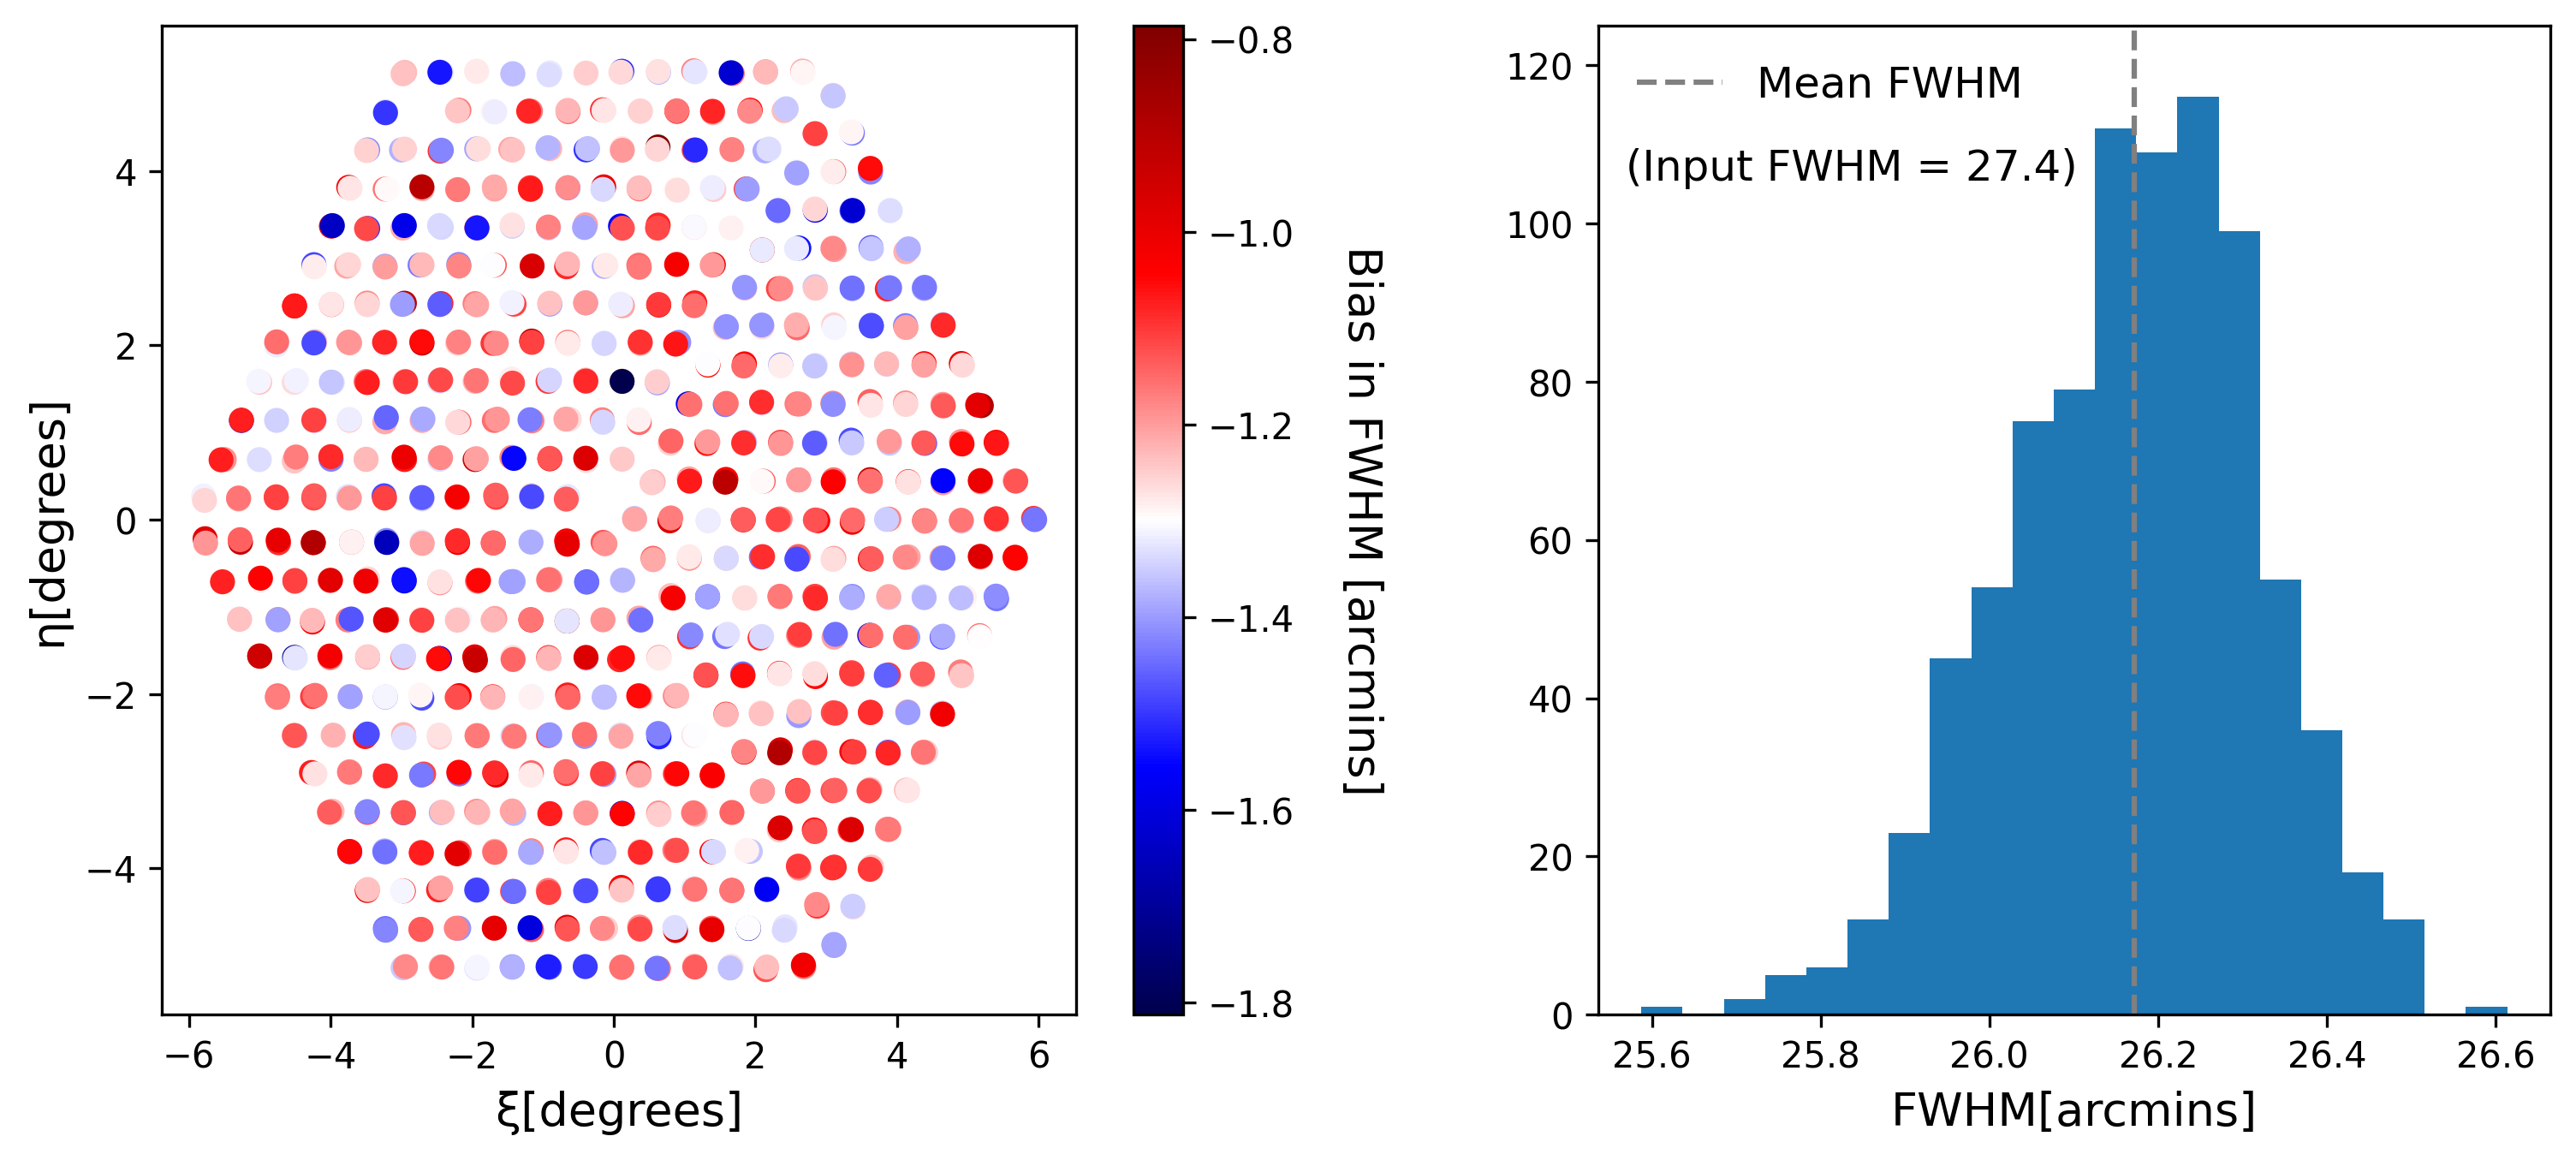

In [23]:
# Compare your results with the input parameters.
# For example, let's check the fitted beam size statistics and look for trends across the focal plane.
xi_fitted, eta_fitted = df['xi0'].to_numpy().astype(float), df['eta0'].to_numpy().astype(float)
fwhm_xi_fitted, fwhm_eta_fitted = df['fwhm_xi'].to_numpy().astype(float), df['fwhm_eta'].to_numpy().astype(float)

# Get the difference in position. Input beam size and ellipticity are derived from 2D Gaussian fits
# of the input beam maps.
input_fwhm = 27.4

# Geometric mean of the beam size in both directions
fitted_fwhm = np.degrees(np.sqrt(fwhm_xi_fitted*fwhm_eta_fitted))*60
delta_fwhm = fitted_fwhm-input_fwhm

# Ellipticity - if you choose to fit a 2D elliptical Gaussian, instead. 
# input_ell = 0.005
# fwhm_major = [np.max([fwhm_xi_fitted[i], fwhm_eta_fitted[i]]) for i in range(len(fwhm_xi_fitted))]
# fwhm_minor = [np.max([fwhm_xi_fitted[i], fwhm_eta_fitted[i]]) for i in range(len(fwhm_xi_fitted))]

# ell = (np.array(fwhm_major)-np.array(fwhm_minor))/(fwhm_xi_fitted+fwhm_eta_fitted)
# delta_ell = ell-input_ell


# Plot using these differences as a color scheme
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), gridspec_kw={'width_ratios': [1.2, 1]}, dpi=300)

v1_lim = np.max(np.abs(np.array([np.nanmin(delta_fwhm), 
                                 np.nanmax(delta_fwhm)])))

im1 = ax1.scatter(np.degrees(xi_fitted), 
                  np.degrees(eta_fitted), 
                  c=delta_fwhm, 
                  cmap='seismic')

cbar = plt.colorbar(im1)
cbar.set_label('Bias in FWHM [arcmins]',labelpad=25, rotation=270, size=13)
ax1.set_xlabel('ξ[degrees]', size=13)
ax1.set_ylabel('η[degrees]', size=13)

im2 = ax2.hist(fitted_fwhm, bins=21)

ax2.set_xlabel('FWHM[arcmins]', size=13)
ax2.vlines(x=fitted_fwhm.mean(),ymin=0,ymax=130, colors='gray', linestyles='--', label='Mean FWHM')
ax2.set_ylim(0,125)
ax2.legend(loc='upper left', frameon=False, fontsize=12)
fig.text(0.6, 0.76, '(Input FWHM = 27.4)', size=12)

fig.subplots_adjust(wspace=0.28)
# plt.savefig(opj(kwargs['img_dir'], fitted_par + '_bias_' +kwargs['obs_id'] + '.png'), bbox_inches='tight')
plt.show()
plt.close()

In [24]:
# The beam is low-biased. Why do you think this is? 
# Try include the filtering in the fitting model and compare your results again.

In [27]:
# Now that we recovered the detector positions we can try to make a beam map.
# In the simplest scenario, where no fancy map-makers are used, we bin the source-centred data of each detector
# and then co-add all maps - here is where pointing errors will shine.

def map_make(az, el, sig, boxx, boxy, npixx, npixy, do_rms=False):
    '''
    Simple map maker
    '''
    map0, nobs, rms = np.zeros((npixx,npixy)), np.zeros((npixx,npixy)), \
      np.zeros((npixx,npixy))

    # Defining the bins
    az_edge = np.linspace(-boxx,boxx,npixx+1)
    el_edge = np.linspace(-boxy,boxy,npixy+1)
    aze = az_edge[:-1]+np.median(np.diff(az_edge))/2.0
    ele = el_edge[:-1]+np.median(np.diff(el_edge))/2.0
    Az, El = np.meshgrid(aze,ele)

    # Binning the rows
    el_binidx = np.digitize(el,el_edge)
    
    for i in range(npixy):
        idx_i = np.where(el_binidx == i)[0]
        sig_i = sig[idx_i]; az_i = az[idx_i]
        # Checking to see if this row is empty
        if not idx_i.any():
            continue
        else:
            # Making sure we have elements outside the range
            # This (hack) ensure digitize/bincount work in a predictable manner
            az_i = np.insert(az_i,0,-(boxx+1)); az_i = np.append(az_i,(boxx+1))
            sig_i = np.insert(sig_i,0,0); sig_i = np.append(sig_i,0)
            az_binidx = np.digitize(az_i,az_edge)

            if do_rms:
                for j in range(npixx):
                    idx2use = np.where(az_binidx == (j+1))[0]
                    #print j
                    #print np.std(sig_i[idx2use])
                    rms[j,i] = np.std(sig_i[idx2use])

            rmap = np.bincount(az_binidx,weights=sig_i)[1:-1]
            ncount = np.bincount(az_binidx)[1:-1]
            nobs[:,i] = ncount
            goodidx = np.where(ncount > 0)[0]
            rmap[goodidx] = rmap[goodidx]/ncount[goodidx]
            map0[:,i] = rmap

    badidx = np.where(nobs == 0)
    map0[badidx] = 0;
    nobs[badidx] = 0;
    rms[badidx] = 0

    return map0.T

# Make single-detector maps from -2 to 2 degrees around the source
boxx, boxy = 2, 2
npixx, npixy = 101, 101

beam_maps = np.zeros((len(xi_fitted), npixx, npixy))
for det_idx in range(len(xi_fitted)):
    
    p_centered_coords, det_center = get_src_centered_tod(q_bore=q_bore, 
                                                         src_idx=max_peak_idxs[det_idx], 
                                                         planet='Jupiter')
    
    xi_det_centered = p_centered_coords[0]-det_center[0]
    eta_det_centered = p_centered_coords[1]-det_center[1]
    
    beam_maps[det_idx,:,:] = map_make(np.degrees(xi_det_centered), 
                                      np.degrees(eta_det_centered), 
                                      data_trunc[det_idx],
                                      boxx=boxx,
                                      boxy=boxy,
                                      npixx=npixx,
                                      npixy=npixy)
    
    


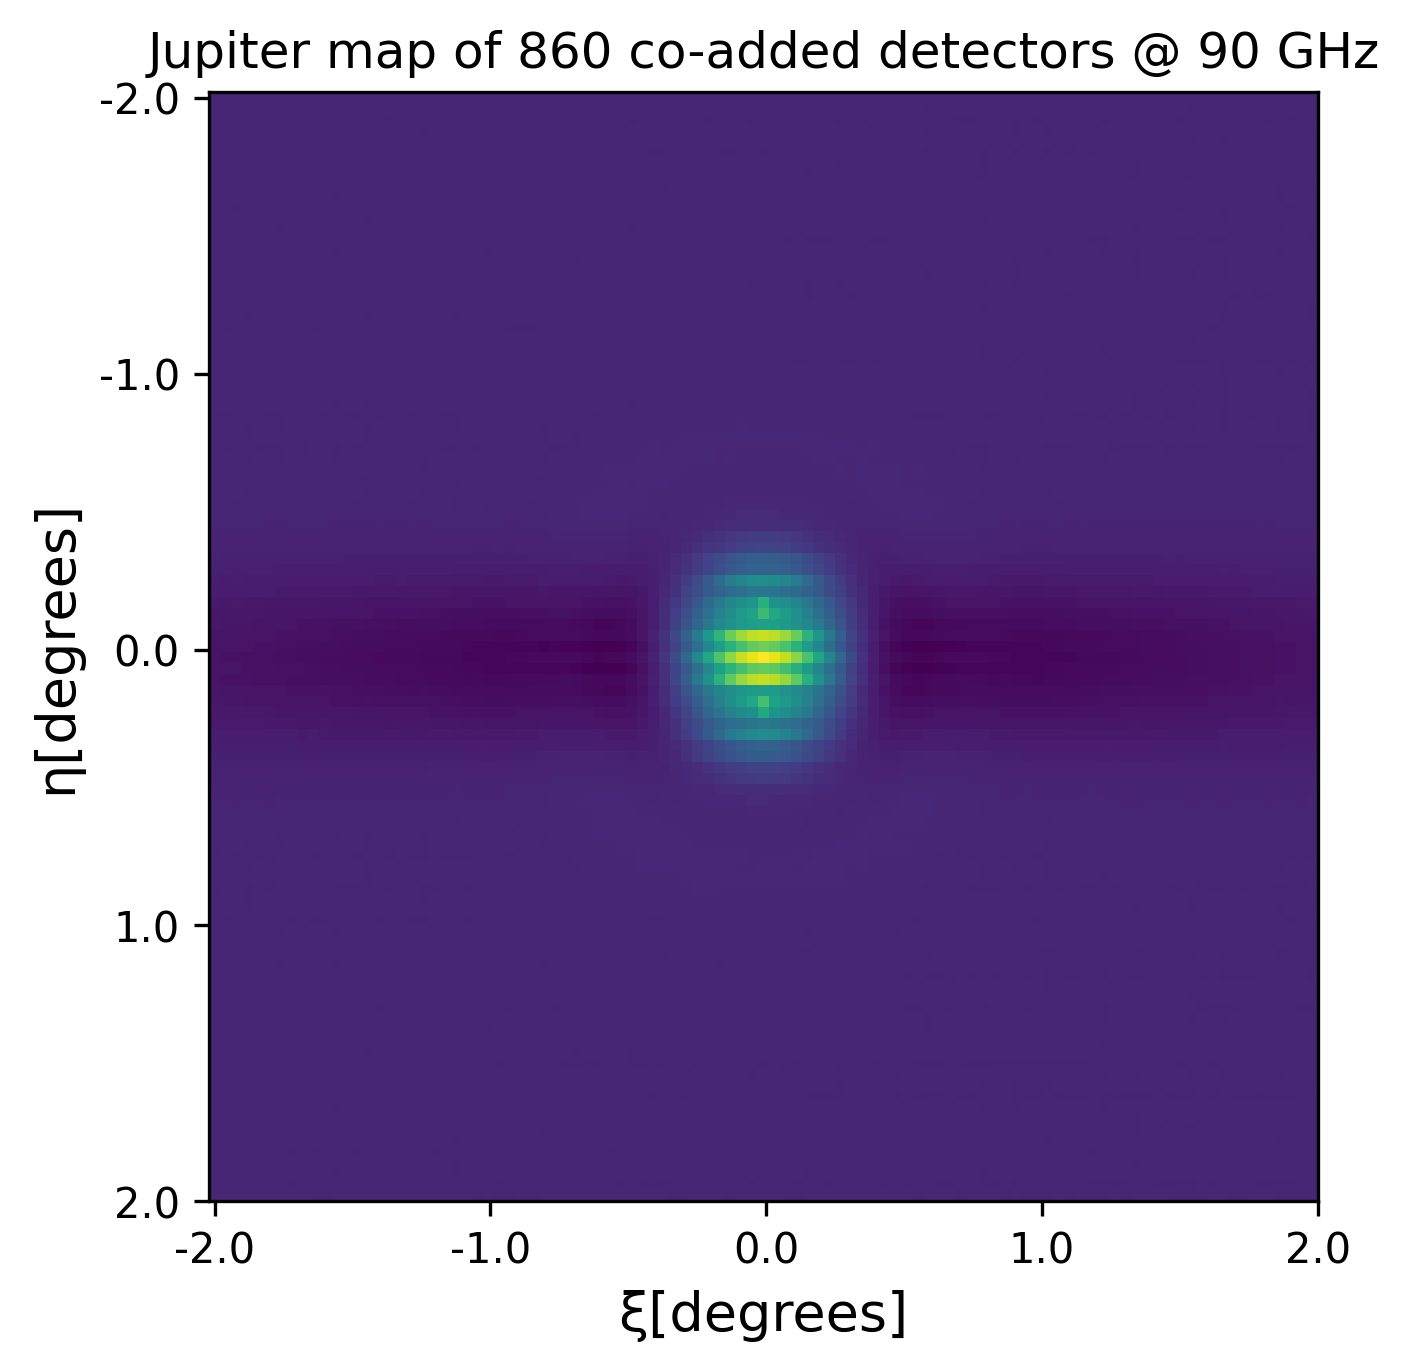

In [38]:
# Look at the co-added beam map across the full detector set.
coadded_map = beam_maps.sum(axis=0)

fig = plt.figure(dpi=300)
ax = fig.add_subplot(111)
ax.imshow(coadded_map)
shape = coadded_map.shape
ax.set_xticks(np.linspace(0,shape[0]-0.5,5), np.linspace(-2,2,5))
ax.set_yticks(np.linspace(0,shape[0]-0.5,5), np.linspace(-2,2,5))
ax.set_xlabel('ξ[degrees]', size=13)
ax.set_ylabel('η[degrees]', size=13)
ax.set_title('Jupiter map of {} co-added detectors @ 90 GHz'.format(len(xi_fitted)))

plt.show()
plt.close()

In [30]:
# Ok this is a bad map, but this is what we get from simply binning the time-streams.
# Fancier map-makers include detector weighting, techniques for (atmospheric) correlated noise mitigation, etc.
# The horizontal stripe around the source is due to the high-pass filtering combined with the chosen scan 
# strategy (constant elevation scans).

In [54]:
# Let's try to make an estimate about the gain.
# What do we need? We need the amplitude and solid angle of the beam.

# For a Gaussian beam, and having already fitted for the beam size, we can estimate the solid angle as:
fitted_fwhm_rad = np.radians(fitted_fwhm.mean()/60)
Omega = 2*np.pi*(fitted_fwhm_rad)**2/(8*np.log(2))

# The gain then will be equal to:
g = 4*np.pi/Omega
g_dB = 10*np.log10(g)

# This is the factor that we need to divide out of our data.

In [56]:
# Now try calibrating some data on your own! Choose between different sources and atmoshperic noise levels
# from the directory: 
# Ready, Set, Go!!